In [17]:
import os
from copy import copy
import numpy as np
import matplotlib.pyplot as plt
from numpy.random import default_rng
rng = default_rng()

In [18]:
os.getcwd()

'/Users/itaicohen/siemese_networks'

#PARAMS

In [19]:
MAX_ITER=100
MIN_PTS=10
THRESHOLD=0.05
NUM_DATA_PTS=10

In [62]:
class RANSAC:
    def __init__(self, n=MIN_PTS, k=MAX_ITER, t=THRESHOLD, d=NUM_DATA_PTS, model=None, loss=None, metric=None):
        self.n = n              # `n`: Minimum number of data points to estimate parameters
        self.k = k              # `k`: Maximum iterations allowed
        self.t = t              # `t`: Threshold value to determine if points are fit well
        self.d = d              # `d`: Number of close data points required to assert model fits well
        self.model = model      # `model`: class implementing `fit` and `predict`
        self.loss = loss        # `loss`: function of `y_true` and `y_pred` that returns a vector
        self.metric = metric    # `metric`: function of `y_true` and `y_pred` and returns a float
        self.best_fit = None
        self.best_error = np.inf

    def fit(self, X, y):
        
        #log/debug parameter i 
        i=0
        ivals=[]
        evals=[]
        
        
        for _ in range(self.k):
            
            #random permutation of the data.
            ids = rng.permutation(X.shape[0]) 
            maybe_inliers = ids[: self.n]
            
            # fit a model to the data (Linear Regression).
            maybe_model = copy(self.model).fit(X[maybe_inliers], y[maybe_inliers])
            
            #returns boolean array
            thresholded = (
                self.loss(y[ids][self.n :], maybe_model.predict(X[ids][self.n :]))
                < self.t
            ) 

            inlier_ids = ids[self.n :][np.flatnonzero(thresholded).flatten()]
            
            #stopping criteria. 
            if inlier_ids.size > self.d: 
                inlier_points = np.hstack([maybe_inliers, inlier_ids])
                better_model = copy(self.model).fit(X[inlier_points], y[inlier_points])

                this_error = self.metric(
                    y[inlier_points], better_model.predict(X[inlier_points])
                )

                if this_error < self.best_error:
                    self.best_error = this_error
                    self.best_fit = better_model
                    
                    #debug
                    print(i,self.best_error)
                    ivals.append(i)
                    evals.append(self.best_error)
                    
            #debug
            i+=1

        return ivals,evals

    def predict(self, X):
        return self.best_fit.predict(X)


def square_error_loss(y_true, y_pred):
    return (y_true - y_pred) ** 2

def mean_square_error(y_true, y_pred):
    return np.sum(square_error_loss(y_true, y_pred)) / y_true.shape[0]

# linear model. 
class LinearRegressor:
    def __init__(self):
        self.params = None

    def fit(self, X: np.ndarray, y: np.ndarray):
        r, _ = X.shape
        X = np.hstack([np.ones((r, 1)), X])
        self.params = np.linalg.inv(X.T @ X) @ X.T @ y
        return self

    def predict(self, X: np.ndarray):
        r, _ = X.shape
        X = np.hstack([np.ones((r, 1)), X])
        return X @ self.params



In [66]:
#ToDo data generator with customed shape. 
regressor = RANSAC(model=LinearRegressor(), loss=square_error_loss, metric=mean_square_error)
X = np.array([-0.848,-0.800,-0.704,-0.632,-0.488,-0.472,-0.368,-0.336,-0.280,-0.200,-0.00800,-0.0840,0.0240,0.100,0.124,0.148,0.232,0.236,0.324,0.356,0.368,0.440,0.512,0.548,0.660,0.640,0.712,0.752,0.776,0.880,0.920,0.944,-0.108,-0.168,-0.720,-0.784,-0.224,-0.604,-0.740,-0.0440,0.388,-0.0200,0.752,0.416,-0.0800,-0.348,0.988,0.776,0.680,0.880,-0.816,-0.424,-0.932,0.272,-0.556,-0.568,-0.600,-0.716,-0.796,-0.880,-0.972,-0.916,0.816,0.892,0.956,0.980,0.988,0.992,0.00400]).reshape(-1,1)
y = np.array([-0.917,-0.833,-0.801,-0.665,-0.605,-0.545,-0.509,-0.433,-0.397,-0.281,-0.205,-0.169,-0.0531,-0.0651,0.0349,0.0829,0.0589,0.175,0.179,0.191,0.259,0.287,0.359,0.395,0.483,0.539,0.543,0.603,0.667,0.679,0.751,0.803,-0.265,-0.341,0.111,-0.113,0.547,0.791,0.551,0.347,0.975,0.943,-0.249,-0.769,-0.625,-0.861,-0.749,-0.945,-0.493,0.163,-0.469,0.0669,0.891,0.623,-0.609,-0.677,-0.721,-0.745,-0.885,-0.897,-0.969,-0.949,0.707,0.783,0.859,0.979,0.811,0.891,-0.137]).reshape(-1,1)
ivals,evals=regressor.fit(X, y)

0 0.04735782970608452
3 0.02674142410552549
14 0.02385756867671798
18 0.012513190034179368
84 0.0057639095812965615


Text(0.5, 1.0, 'errors vs iterations')

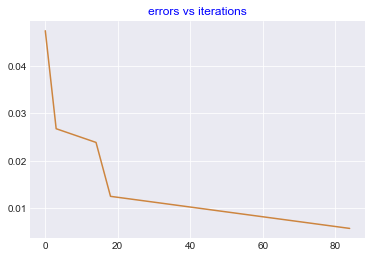

In [75]:
plt.plot(ivals,evals, c="peru")
plt.title("errors vs iterations",c="b")

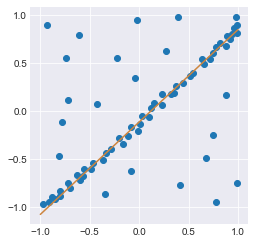

In [76]:
plt.style.use("seaborn-darkgrid")
fig, ax = plt.subplots(1, 1)
ax.set_box_aspect(1)

plt.scatter(X, y)

line = np.linspace(-1, 1, num=100).reshape(-1, 1)
plt.plot(line, regressor.predict(line), c="peru")
plt.show()

# More on parameters

Let omega be the probability of an inlier in the data:
$$
\omega=P(\text{inlier})=\frac{\#\text{inliers}}{|\text{data}|}
$$





Let $1-p$ be the probability of never picking $n$ inliers by $k$ iterations
$$
1-p=(1-\omega^n)^k
$$

$$
k=\frac{\log(1-p)}{\log(1-w^n)}
$$



/Users/itaicohen/siemese_networks
